In [66]:
## Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from keras.datasets import mnist
plt.style.use('dark_background')
%matplotlib inline

In [67]:
##Load Mnist data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0] , X_train.shape[1]* X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]* X_test.shape[2])

num_features = X_train.shape[0]
num_samples = X_train.shape[1]

## Normalize data
xmax = np.amax(X_train) 
xmin = np.amin(X_train)
X_train = (X_train - xmin)/(xmax - xmin)
X_test = (X_test - xmin)/(xmax - xmin)

##print
print('mnist SET')
print(num_features, ' Features')
print(num_samples, ' Training samples')

mnist SET
60000  Features
784  Training samples


In [68]:
##Parameters for the autoencoder
batchsize = 256
max_epochs = 50
latest_dim = 128
hidden_dim = 512
learning_rate = 1e-3
original_dim = X_train.shape[1] 
print('Original dimension:', original_dim)


Original dimension: 784


In [69]:
import tensorflow as tf
##convert numpy array to tensor.data.Dataset
training_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(batchsize)
testing_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(batchsize)


In [70]:
## custom layer 

class Encoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.latent_layer = tf.keras.layers.Dense(units=latent_dim, activation=tf.nn.relu)
    
    ## method for forward propagation
    def call(self, input_features):
        activation = self.hidden_layer(input_features)
        return self.latent_layer(activation)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, original_dim):
        super(Decoder, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(units=hidden_dim, activation=tf.nn.relu)
        self.output_layer = tf.keras.layers.Dense(units=original_dim, activation=tf.nn.relu)
    ## method for forward propagation
    def call(self, encode):
        activation = self.hidden_layer(encode)
        return self.output_layer(activation)

In [71]:
# Define the model
class Autoencoder(tf.keras.Model):
    def __init__(self, hidden_dim, latent_dim, original_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, latent_dim)
        self.decoder = Decoder(hidden_dim, original_dim)
        self.loss = []
        
    ## method for forward propagation     
    def call(self, input_features):
        encode = self.encoder(input_features)
        reconstructed = self.decoder(encode)
        return reconstructed
  
## build mdel      
model = Autoencoder(hidden_dim= hidden_dim, 
                    latent_dim = latest_dim, 
                    original_dim = original_dim)

In [72]:
##loss function
def loss(preds, real):
    return tf.reduce_mean(tf.square(tf.subtract(preds, real)))

##optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)


In [73]:
## training
def train(loss, model, opt, original):
    with tf.GradientTape() as tape:
        preds = model(original)
        reconstruction_error = loss(preds, original)
    gradients = tape.gradient(reconstruction_error, model.trainable_variables)
    gradient_variables = zip(gradients, model.trainable_variables)
    opt.apply_gradients(gradient_variables)
    return reconstruction_error


In [74]:
## train the network
def train_loop(model, opt, loss, dataset, epochs):
    for epoch in range(epochs):
        epoch_loss = 0
        for step, batch_features in enumerate(dataset):
            loss_values = train(loss, model, opt, batch_features)
            epoch_loss += loss_values
        #epoch_loss = epoch_loss / batchsize
        model.loss.append(epoch_loss)
        print('Epoch {}/{}. Loss: {}'.format(epoch + 1, epochs, epoch_loss.numpy()))

In [85]:
## train the autoencoder

train_loop(model, optimizer, loss=loss, dataset=training_dataset, epochs=max_epochs)


InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Sub]

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

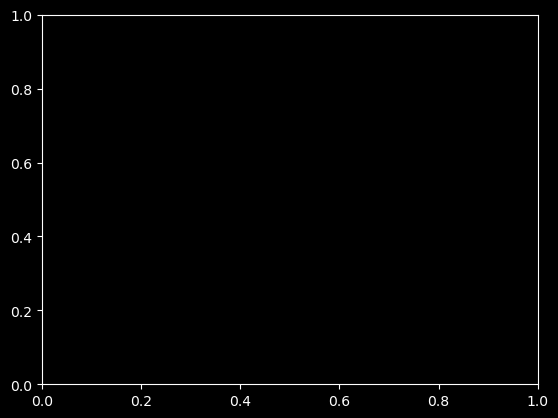

In [ ]:
##plot loss
plt.plot(range(max_epochs), model.loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
